# Basic classification: Classify images of clothing
A tensorflow serving style service example using BentoML


![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=tensorflow&ea=tensorflow_2_fashion_mnist&dt=tensorflow_2_fashion_mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
NAME = "fashion_mnist_serving"

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import io

# TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = _train_images / 255.0
test_images = _test_images / 255.0

In [5]:
class FashionMnist(tf.keras.Model):
    def __init__(self):
        super(FashionMnist, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    
    @staticmethod
    def image_bytes2tensor(inputs):
        inputs = tf.map_fn(lambda i: tf.io.decode_png(i, channels=1), inputs, dtype=tf.uint8)
        inputs = tf.cast(inputs, tf.float32)
        inputs = (255.0 - inputs) / 255.0
        inputs = tf.reshape(inputs, [-1, 28, 28])
        return inputs

    @tf.function(input_signature=[tf.TensorSpec(shape=(None,), dtype=tf.string)])
    def predict_image(self, inputs):
        inputs = self.image_bytes2tensor(inputs)
        return self(inputs)
    
    def call(self, inputs):
        return self.cnn(inputs)


## test the image preprocessing

Ankle boot


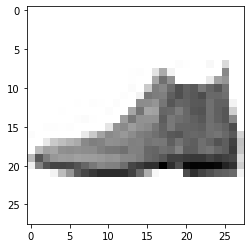

In [6]:
# pick up a test image
d_test_img = _test_images[0]
print(class_names[test_labels[0]])

plt.imshow(255.0 - d_test_img, cmap='gray')

## train the model


In [7]:
model = FashionMnist()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=1)

Train on 60000 samples
60000/60000 [==============================] - 6s 106us/sample - loss: 0.4959 - accuracy: 0.8255


# Define & save BentoService

In [8]:
%%writefile tensorflow_fashion_mnist.py

import base64
import bentoml
import tensorflow as tf

from bentoml.artifact import (
    TensorflowSavedModelArtifact,
)
from bentoml.handlers import TensorflowTensorHandler, ClipperStringsHandler

try:
    tf.config.set_visible_devices([], 'GPU')  # disable GPU, required when served in docker
except:
    pass

FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_dependencies=['tensorflow', 'numpy', 'pillow'])
@bentoml.artifacts([TensorflowSavedModelArtifact('model')])
class FashionMnistTensorflow(bentoml.BentoService):

    @bentoml.api(TensorflowTensorHandler)
    def predict(self, inputs):
        outputs = self.artifacts.model.predict_image(inputs)
        output_classes = tf.math.argmax(outputs, axis=1)
        return [FASHION_MNIST_CLASSES[o] for o in output_classes]

Overwriting tensorflow_fashion_mnist.py


In [9]:
from tensorflow_fashion_mnist import FashionMnistTensorflow

bento_svc = FashionMnistTensorflow()
bento_svc.pack("model", model)
saved_path = bento_svc.save()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/bentoml-temp-371bugw9/FashionMnistTensorflow/artifacts/model_saved_model/assets
[2020-05-19 05:29:38,688] INFO - BentoService bundle 'FashionMnistTensorflow:20200519052920_E6E72C' saved to: /home/ec2-user/bentoml/repository/FashionMnistTensorflow/20200519052920_E6E72C


In [10]:
# tf_model_path = f"{saved_path}/FashionMnistTensorflow/artifacts"
# !cp -r {tf_model_path}/model_saved_model {tf_model_path}/1

# Build & Run TF-Serving Service

In [11]:
from bentoml.utils import detect_free_port
PORT = detect_free_port()
print(PORT)

43033


In [12]:
TMP_MODEL_DIR = "/tmp/test-model/"
TMP_MODEL_SAVE_DIR = "/tmp/test-model/1"
tf.saved_model.save(model, TMP_MODEL_SAVE_DIR, signatures=model.predict_image)
print(f'tensorflow_model_server --rest_api_port={PORT} --model_name={NAME} --model_base_path={TMP_MODEL_DIR}')
server_url = f"http://127.0.0.1:{PORT}/v1/models/{NAME}:predict"
server_url

INFO:tensorflow:Assets written to: /tmp/test-model/1/assets
tensorflow_model_server --rest_api_port=43033 --model_name=fashion_mnist_serving --model_base_path=/tmp/test-model/


'http://127.0.0.1:43033/v1/models/fashion_mnist_serving:predict'

# Run in Docker with 1 CPU

In [54]:
%%writefile {TMP_MODEL_DIR}batching_parameters.conf
num_batch_threads { value: 1 }
batch_timeout_micros { value: 2000}
max_batch_size {value: 1000}
max_enqueued_batches {value: 1000}

Overwriting /tmp/test-model/batching_parameters.conf


In [55]:
!docker pull tensorflow/serving
!docker run -t --rm -p {PORT}:8501 -v {TMP_MODEL_DIR}:/models/{NAME} -e MODEL_NAME={NAME} tensorflow/serving --enable_batching=true --batching_parameters_file=/models/{NAME}/batching_parameters.conf

pen files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too many open files
[warn] Error from accept() call: Too

# generate test requests

In [14]:
import tensorflow as tf
from io import BytesIO
import matplotlib.pyplot as plt
import base64
import json
import random


def get_request_producer():
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    url = server_url
    method = "POST"
    headers = {"content-type": "application/json"}
    pred_sentence =  "The acting was a bit lacking."

    def _gen_data(size=1):
        sio = BytesIO()
        
        d_test_img = _test_images[random.randint(0, len(_test_images))]
        label = class_names[test_labels[0]]
        plt.imsave(sio, 255.0 - d_test_img, cmap='gray')
        img_bytes = sio.getvalue()
    
        img_b64 = base64.b64encode(img_bytes).decode()

        data = json.dumps(
               {"instances": [{"b64": img_b64}] * size}
        )
        return url, method, headers, data

    return _gen_data

# test
get_request_producer()(1)

('http://127.0.0.1:35035/v1/models/fashion_mnist_serving:predict',
 'POST',
 {'content-type': 'application/json'},
 '{"instances": [{"b64": "iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAxVJREFUSIm1lT9P8l4Uxz8txUJDkf+IVfmX6ACJiZuTi3HiVbgbHX0zTsY3oJurDibEgTioMSGoaAkmIBQitBSe4RdJzG94rkmfs92T2/Pp99z7PVeazWYzBGJ/f5/RaASAqqpsb29zcXFBpVKh2+1yfHwsUgZFaBfQ7/cB+Pj4oNlsUq/XabVaWJZFqVQSLSMGvLy8pFqtsrq6SigUIhwOk0qlMAyDp6cnNE2j0+kQi8X+WksWAd7c3NDv99F1nVgsRjgcBuD19ZV4PM79/T31el2klBgwlUqxu7uLqqoMh0NkWabdbuM4Di8vL+i6zvv7uxBQqKWTyYSNjQ2m0yn9fp9Go0GtVsMwDDY3NymVSvh8PiGgkMJut8vz8zOJRIJ8Pk+hUKDZbFIoFFhfX6fX683b7AlQkiT8fj+yLPP29kY+nyebzTIcDul0Opim6a3C6XTK4eEhR0dHpFIpdF0nm81iWRbdbpfZbIamad4Bg8Eg5+fnABSLRQKBAIZhoKoqOzs7LC8ve6twZWWF6+trrq6uGI/HrK2tkUwmabfb5PN5kskkkiR5BwyFQui6TqvV4uHhgXK5TDqdxjRNzs7OuLu7IxqNegfMZDKMRiN0Xcfn8xGJRDAMg2KxyMHBAVtbWwiOZDFgIpHAsiwcx0GSJGRZJhKJMJlMAIjH4/j9fu+A4XCYdruNaZrI8n+f6LrO7e0tJycnNBoNb30YDAZRFIVKpUK5XAYgl8uxt7dHJBLh8/NTWKHQaAs

# Test with requests

In [15]:
import requests
url, _, headers, data = get_request_producer()()
json_response = requests.post(url, data=data, headers=headers)
print(json_response)
print(json_response.text)

<Response [200]>
{
    "predictions": [[6.64832598e-08, 1.02976494e-09, 3.86024546e-08, 8.89219809e-09, 3.29046976e-08, 0.000425829843, 4.98415318e-07, 0.587318301, 0.000212660845, 0.412042588]
    ]
}


## Benchmark

In [16]:
import os


def init_file(file_name):
    if os.path.exists(LOG_FILE):
        return
    with open(file_name, "a") as lf:
        lf.write('"model name","test_users","total succ","succ/sec","avg resp time",'
                 '"total fail","fail/sec","avg fail resp time","client health"')
        lf.write('\n')


def log_result(b, name, file_name, test_user):
    init_file(file_name)
    self = b.stat

    result = []
    result.append(name)
    result.append(test_user)
    result.append(self.success)
    result.append(self.success / max(self.sess_time, 1))
    result.append(sum(self.succ_times) / max(self.success, 1))

    result.append(self.fail)
    result.append(self.fail / max(self.sess_time, 1))
    result.append(sum(self.exec_times) / max(self.fail, 1))
    
    result.append((1 - self.client_busy / max(self.req_total, 1)))

    log_str = ','.join(str(r) for r in result)
    with open(file_name, "a") as lf:
        lf.write(log_str)
        lf.write('\n')

        
LOG_FILE = 'benchmark_result.csv'

In [17]:
from bentoml.utils.benchmark import BenchmarkClient
import asyncio


for TEST_USER in range(100, 1600, 100):
    b = BenchmarkClient(get_request_producer(), lambda: 1, timeout=0.35)
    await b._start_session(60, TEST_USER, TEST_USER)
    log_result(b, f'{NAME}', LOG_FILE, TEST_USER)
    b.killall()
    await asyncio.sleep(15)

======= Session started! =======

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │        0 │             nan │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │        0 │             nan │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛
------ 100 users spawned ------

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │     193 │     90.5 │       0.0020562 │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │      0   │     nan         │                  

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-14-fb8dda9876ae>", line 23, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000



╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │   11710 │    595.5 │        0.224641 │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │      37 │      7.5 │        0.834186 │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │   13187 │    555   │        0.251073 │ 99.75870909365104 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │      75 │     13.5 │        0.85414  │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-14-fb8dda9876ae>", line 23, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000



╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │   16183 │      506 │        0.34952  │ 99.41022678908008 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │     264 │       47 │        0.746034 │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │   17376 │      533 │        0.326725 │ 99.2756903576279  │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │     296 │       16 │        0.8707   │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-14-fb8dda9876ae>", line 23, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000
Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/util